### Latent factor 

### Reading dataset & pre-processing - same process as the Item-based CF

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving movies.csv to movies.csv
Saving ratings.csv to ratings.csv


In [ ]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_mx = ratings.pivot_table('rating', index='userId', columns='movieId')

rating_movies = pd.merge(ratings, movies, on='movieId')
ratings_mx = rating_movies.pivot_table('rating', index='userId', columns='title')

### Create matrix decomposition function based on gradient descent

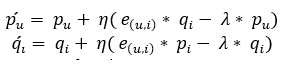

In [ ]:
def mx_factorization(plot_rmse, plot_iter,R, K, iters=200, alpha_rate=0.01, r_lambda = 0.01):
    numUsers, numItems = R.shape
    # Specify the size of the P and Q matrices and initialize the random values with a normal distribution
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(numUsers, K))
    Q = np.random.normal(scale=1./K, size=(numItems, K))

    break_count = 0
       
    # Save row position, column position, and value with R> 0 in a nonZeros list object 
    nonZeros = [ (i, j, R[i,j]) for i in range(numUsers) for j in range(numItems) if R[i,j] > 0 ]
   
    # Updating P and Q using Stochastic Gradient Descent (SGD) 
    for iter in range(iters):
        for i, j, r in nonZeros:
            # Find the error value that is the difference between the actual value and the predicted value
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Applying updated values to the regularization
            P[i,:] = P[i,:] + alpha_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + alpha_rate*(eij * P[i, :] - r_lambda*Q[j,:])
       
        rmse = get_rmse(R, P, Q, nonZeros)
        plot_rmse.append(rmse)
        plot_iter.append(iter)
        if (iter % 10) == 0 :
            print("The number of iterations for updating p and q : ", iter, " rmse : ", rmse)
            
    return P, Q

In [ ]:
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, nonZeros):
    error = 0
    # Computing predicted R matrix using dense matrices P and Q'
    full_p_mx = np.dot(P, Q.T)
    
    # Extracting the non-null value as index from R vector and compute R matrix and predicted R matrix
    col_nonZero_indx = [nonZero[0] for nonZero in nonZeros]
    row_nonZero_indx = [nonZero[1] for nonZero in nonZeros]
    R_nonZeros = R[col_nonZero_indx, row_nonZero_indx]
    full_p_mx_nonZeros = full_p_mx[col_nonZero_indx, row_nonZero_indx]
    mse = mean_squared_error(R_nonZeros, full_p_mx_nonZeros)
    rmse = np.sqrt(mse)
    
    return rmse

In [ ]:
#creating empty list to append the iteration value and the RMSE value for the visualization
plot_rmse = []
plot_iter = []
# Implementing SGD using the alpha values as 0.01 and the lambda value as 0.01 as well
P, Q = mx_factorization( plot_rmse,plot_iter,ratings_mx.values, K=50, iters=200, alpha_rate=0.01, r_lambda = 0.01)
pred_mx = np.dot(P, Q.T)

The number of iterations for updating p and q :  0  rmse :  2.9023619751336867
The number of iterations for updating p and q :  10  rmse :  0.7335768591017927
The number of iterations for updating p and q :  20  rmse :  0.5115539026853442
The number of iterations for updating p and q :  30  rmse :  0.37261628282537446
The number of iterations for updating p and q :  40  rmse :  0.2960818299181014
The number of iterations for updating p and q :  50  rmse :  0.2520353192341642
The number of iterations for updating p and q :  60  rmse :  0.22487503275269854
The number of iterations for updating p and q :  70  rmse :  0.20685455302331543
The number of iterations for updating p and q :  80  rmse :  0.19413418783028685
The number of iterations for updating p and q :  90  rmse :  0.18470082002720403
The number of iterations for updating p and q :  100  rmse :  0.17742927527209104
The number of iterations for updating p and q :  110  rmse :  0.1716522696470749
The number of iterations for upda

In [ ]:
ratings_pred_mx = pd.DataFrame(data=pred_matrix, index= ratings_matrix.index,
                                   columns = ratings_mx.columns)

ratings_pred_mx.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,1.623927,3.910138,4.775403,3.837260,3.875488,1.550801,2.929129,2.680321,3.225626,3.251925,2.778350,3.331543,2.391855,3.199047,4.148949,1.852731,3.269642,3.448719,4.458060,3.719499,3.231820,3.521511,3.866924,3.961768,4.957933,4.075665,3.509040,3.923190,3.210152,4.374122,...,3.546313,3.207635,2.082641,3.302390,1.821505,3.814172,4.227119,3.699006,3.009256,4.605246,4.712096,4.284418,3.095067,3.214574,0.990303,1.805794,4.588016,2.295002,4.173353,0.327724,4.817989,1.902907,3.557027,2.881273,3.766529,2.703354,2.395317,2.373198,4.749076,4.281203,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,1.489588,3.617857,3.785199,3.168660,3.537318,0.995625,3.969397,2.173005,3.464055,2.475622,3.413724,2.665215,1.828840,3.322109,2.654698,1.469953,3.035060,3.163879,4.244324,2.727754,2.879571,3.124665,3.773794,3.774747,3.175855,3.458016,2.923885,3.303497,2.806202,3.504966,...,3.289954,2.677164,2.087793,3.388524,1.783418,3.267824,3.661620,3.131275,2.475330,3.916692,4.197842,3.987094,3.134310,2.827407,0.829738,1.380996,3.974255,2.685338,3.902178,0.293003,3.064224,1.566051,3.095034,2.769578,3.956414,2.493763,2.236924,1.775576,3.909241,3.799859,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,0.881095,1.813452,2.687841,1.908641,2.228256,0.695248,1.146590,1.536595,0.809632,1.561342,1.820714,1.097596,1.216409,1.347617,1.760926,0.622817,1.786144,1.934932,2.332054,2.291151,1.983643,1.785523,2.265654,2.055809,2.459728,2.092599,2.512530,2.928443,1.777471,1.808872,...,1.779506,2.222377,1.448616,2.340729,1.658322,2.231055,2.6

Ploting the RMSE values

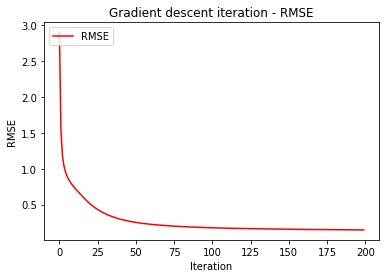

In [ ]:
from matplotlib import pyplot as plt 
plt.plot(plot_iter,plot_rmse, color="red")
plt.title('Gradient descent iteration - RMSE')
plt.ylabel('RMSE')
plt.xlabel('Iteration')
plt.legend(['RMSE', 'val'], loc='upper left')
plt.show()

### Recommend items in order of highest predicted score

Movie recommendation through item-based CF among movies that users have not watched

In [ ]:
def unseen_movies(ratings_mx, userId):
    # Return Series type from the userId infromation as a parameter  
    # The return value which is user_rating is the object value that has movie title as an index 
    user_rating = ratings_mx.loc[userId,:]
    
    # If user_rating is greater than 0, it is a previously watched movie. Extract target index and make list object
    prvsly_watched = user_rating[ user_rating > 0].index.tolist()
    
    # Make all movie names into list objects
    movies_list = ratings_mx.columns.tolist()
    
    # As a list comprehension, movies corresponding to prvsly_watched are excluded from movies_list. 
    unseen_list = [ movie for movie in movies_list if movie not in prvsly_watched]
    
    return unseen_list

Recommends the movies with the highest predicted ratings of movies that the user did not watch from the data set rated by item-based similarity

In [ ]:
def rcmd_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # The user ID index and the movie name column entered in unseen_list are extracted from the prediction rating DataFrame 
    # and sorted in the order of the highest prediction rating
    rcmd_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return rcmd_movies
    
# Extract movie names that users do not watch 
unseen_list = unseen_movies(ratings_mx, 7)

# Recommeding movies using item-based CF  
rcmd_movies = rcmd_movie_by_userid(ratings_pred_mx, 7, unseen_list, top_n=10)

# Creating a dataframe for predicted score 
rcmd_movies = pd.DataFrame(data=rcmd_movies.values,index=rcmd_movies.index,columns=['pred_score'])
rcmd_movies


,pred_score
title,
Twister (1996),5.537622
Schindler's List (1993),5.478221
Ghostbusters (a.k.a. Ghost Busters) (1984),5.459786
Snatch (2000),5.346037
Speed (1994),5.285207
"Christmas Story, A (1983)",5.262388
Pulp Fiction (1994),5.179681
Reservoir Dogs (1992),5.144662
Men in Black (a.k.a. MIB) (1997),5.132820
